# 버전 설명 
- 시계열 데이터를 (-1,69,4)형태로 shape 바꾼 다음 LSTM 적용 
- Two stacked Bidirectional LSTM을 적용했을 때 이상 탐지 실패 
- Conv 적용 진행 

데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
import tqdm

from sklearn.impute import SimpleImputer

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [ ]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

## input 데이터 로드 

In [ ]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 

In [ ]:
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

In [ ]:
df.head()

,Index,Lot,Time,pH,Temp,Current,date
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06


## output 데이터 로드

In [ ]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [ ]:
df['error']=0

In [ ]:
def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df

In [ ]:
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


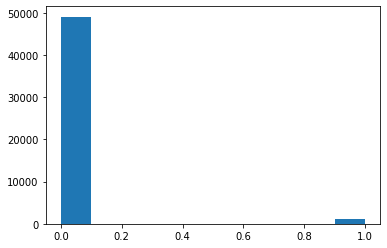

In [ ]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

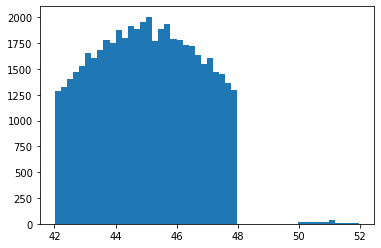

In [ ]:
plt.hist(df['Temp'],bins=50)
plt.show()

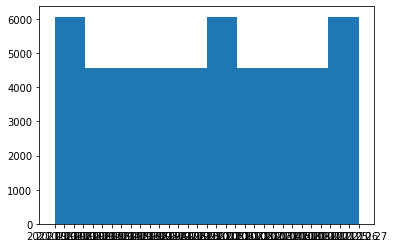

In [ ]:
plt.hist(df['date'])
plt.show()

In [ ]:
np.array(df).shape

(50094, 8)

# 전처리

## 컬럼제거

In [ ]:
input = np.array(df[['pH','Temp','Current','error']])
input

array([[10.37, 42.87,  7.34,  0.  ],
       [10.9 , 42.7 ,  8.26,  0.  ],
       [ 9.61, 42.37,  8.46,  0.  ],
       ...,
       [ 9.86, 46.54,  8.15,  0.  ],
       [10.52, 47.88,  7.97,  0.  ],
       [10.97, 43.02,  8.98,  0.  ]])

## 시계열 분할 

In [ ]:
input = input.reshape(-1,69,4)
input.shape

(726, 69, 4)

output 제작

In [ ]:
output = np.zeros(726)
for index in range(726):
  temp = input[index]
  if temp[:,3].sum()==69:
    output[index]=1

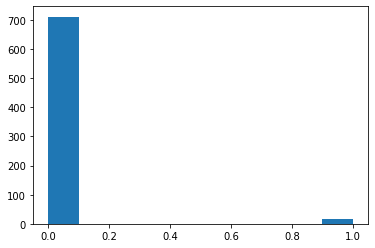

In [ ]:
plt.hist(output)
plt.show()

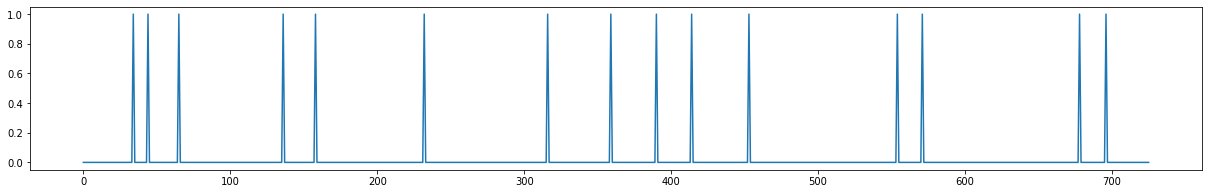

In [ ]:
plt.figure(figsize = (21,3))
plt.plot(np.arange(len(output)),output)
plt.show()

train : 450, valid 100, test rest 

## Train - test - valid 분할 

In [ ]:
print(input.shape,output.shape)

(726, 69, 4) (726,)


In [ ]:
input = input[:,:,:3]

In [ ]:
train_x = input[:450]
train_y = output[:450]

valid_x = input[450:550]
valid_y = output[450:550]

test_x = input[550:]
test_y = output[550:]

## min max scaling 

In [ ]:
train_x.shape

(450, 69, 3)

In [ ]:
max = np.max(np.max(np.concatenate([train_x,valid_x]),axis=0),axis=0)
min = np.min(np.min(np.concatenate([train_x,valid_x]),axis=0),axis=0)
print(max,min)

[11.99 51.95  8.99] [ 9.51 42.01  5.51]


In [ ]:
def scaling(df,max,min):
  scaled_df = (df-min)/(max-min)
  return scaled_df

In [ ]:
train_x

array([[[10.37, 42.87,  7.34],
        [10.9 , 42.7 ,  8.26],
        [ 9.61, 42.37,  8.46],
        ...,
        [ 9.84, 42.87,  8.67],
        [10.94, 46.15,  8.1 ],
        [ 9.78, 42.34,  8.94]],

       [[ 9.84, 46.73,  8.3 ],
        [10.67, 46.06,  7.4 ],
        [ 9.74, 43.1 ,  8.04],
        ...,
        [ 9.51, 47.44,  8.27],
        [10.35, 47.89,  7.36],
        [ 9.95, 47.29,  7.54]],

       [[10.69, 45.85,  7.28],
        [10.1 , 42.98,  8.2 ],
        [10.37, 42.04,  8.69],
        ...,
        [ 9.69, 43.99,  8.12],
        [10.59, 45.14,  8.84],
        [10.82, 46.42,  7.37]],

       ...,

       [[10.35, 43.92,  8.46],
        [10.  , 43.34,  8.02],
        [10.15, 45.65,  8.4 ],
        ...,
        [ 9.57, 47.37,  8.63],
        [10.29, 42.3 ,  7.89],
        [10.13, 43.45,  7.17]],

       [[10.64, 43.83,  8.95],
        [10.23, 45.08,  7.81],
        [ 9.86, 46.46,  7.89],
        ...,
        [10.27, 46.13,  8.77],
        [10.61, 44.9 ,  7.61],
        [ 9.67,

In [ ]:
train_x = scaling(train_x,max,min)
valid_x = scaling(valid_x,max,min)
test_x = scaling(test_x,max,min)

#모델

## 사전 선언 - 모듈, 콜백

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=20)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=20,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [model_check_point, plot_losses, reduce_lr]

## Conv +  Two stacked Bidirectional LSTM  

In [ ]:
#Env 데이터 파트 
def model():
  input = Input((69,3)) #<---- shape 
  x = Conv2D(128,(3,3),padding='same')
  x = Bidirectional(LSTM(128,return_sequences= True))(input) #bidirec
  x = Bidirectional(LSTM(128))(x)
  x = Flatten()(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation ='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(32, activation ='relu')(x)
  x = BatchNormalization()(x)
  output = Dense(2,activation = 'softmax')(x)

  model = Model(input,output)
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
  return model

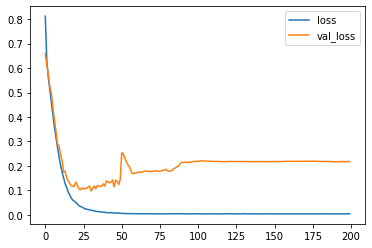

loss =  0.004147982690483332 , val_loss =  0.21766430139541626
13/13 [==============================] - 0s 33ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2177 - val_accuracy: 0.9556 - lr: 2.5600e-09


In [ ]:
model = model()
model.fit(train_x,train_y, epochs=200, verbose=1, batch_size=32, validation_split=0.1,callbacks=callbacks)

예측

In [ ]:
y_ = model.predict(test_x)
predicted = np.argmax(y_,axis=1)

In [ ]:
import seaborn as sns 

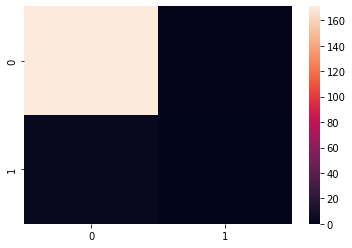

[[171   1]
 [  4   0]]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predicted)
sns.heatmap(cm)
plt.show()
print(cm)
#x : predicted, y: actual label 

실제 클래스 : 정상 142, 비정상 4개
예측 : 정상 142개 중 1개를 비정상으로 오판, 비정상 4개 모두 예측 실패 

In [ ]:
print(classification_report(test_y, predicted, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       172
           1       0.00      0.00      0.00         4

    accuracy                           0.97       176
   macro avg       0.49      0.50      0.49       176
weighted avg       0.95      0.97      0.96       176



## Vanila LSTM + regression 

In [ ]:
from tensorflow.keras.layers import RepeatVector,TimeDistributed

In [ ]:
#Env 데이터 파트 
def model_regression():
  input = Input((69,3)) #<---- shape 
  x = Conv2D(128,(3,3),padding='same')
  x = Bidirectional(LSTM(128,return_sequences= True))(input) #bidirec
  x = Bidirectional(LSTM(128))(x)
  x = Flatten()(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation ='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(32, activation ='relu')(x)
  x = BatchNormalization()(x)
  output = Dense(1,activation = 'sigmoid')(x)

  model = Model(input,output)
  model.compile(optimizer='adam', loss="mse",metrics = ['mae'])
  return model

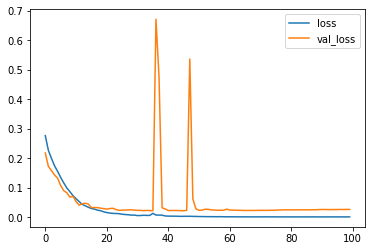

loss =  0.0006981126498430967 , val_loss =  0.02603880874812603
13/13 [==============================] - 0s 33ms/step - loss: 6.9811e-04 - mae: 0.0238 - val_loss: 0.0260 - val_mae: 0.0595 - lr: 4.0000e-05


In [ ]:
model = model_regression()
history = model.fit(train_x, train_y, epochs=100, batch_size=32, validation_split=0.1,callbacks = callbacks)

예측

In [ ]:
y_ = model.predict(test_x)
y_.shape

(176, 1)

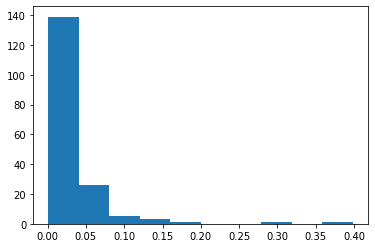

In [ ]:
plt.hist(y_)
plt.show()

In [ ]:
np.where(y_>0.25)

(array([ 58, 163]), array([0, 0]))

In [ ]:
test_y[[58,163]]

array([0., 0.])

## 머신러닝 

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_train_x = train_x.reshape(-1,69*3)

In [ ]:
svc_train_x.shape, train_y.shape

((450, 207), (450,))

In [ ]:
svc = SVC(kernel = 'linear')
svc.fit(svc_train_x, train_y) 

SVC(kernel='linear')

예측

In [ ]:
svc_test_x = test_x.reshape(-1,69*3)

In [ ]:
y_ = svc.predict(svc_test_x)

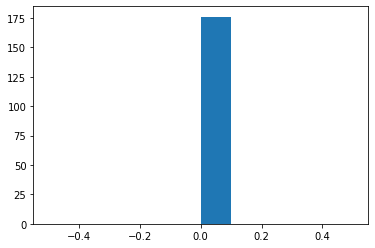

In [ ]:
plt.hist(y_)
plt.show()

## SVDD